In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

In [351]:
train_ds = pd.read_csv("nlp-getting-started/encoded_train_large.csv", index_col=False)
test_ds = pd.read_csv("nlp-getting-started/encoded_test_large.csv", index_col=False)

In [352]:
train_ds = np.array(train_ds)
test_ds = np.array(test_ds)

In [353]:
train_data, val_data = train_test_split(train_ds, test_size=0.2)

In [354]:
train_target = train_data[:, -1]
train_features = train_data[:, :-1]
val_target = val_data[:, -1]
val_features = val_data[:, :-1]
test_features = test_ds

# Dimensionality Reduction

In [355]:
pca_100 = PCA(n_components=100)
pca_10 = PCA(n_components=10)
pca_2 = PCA(n_components=2)

pca_list = [pca_100, pca_10, pca_2]
dim_list = [768, 100, 10, 2]

In [356]:
for pca in pca_list:
    pca.fit(train_features)

In [357]:
train_features_list = [train_features]
val_features_list = [val_features]
test_features_list = [test_features]

for pca in pca_list:
    train_features_list.append(pca.transform(train_features))
    val_features_list.append(pca.transform(val_features))
    test_features_list.append(pca.transform(test_features))

Just a plot to see the PCA with 2 components

In [358]:
train_features_list[-1].shape, train_target.shape

((5176, 2), (5176,))

In [359]:
Z_0 = train_features_list[-1][np.argwhere(train_target.reshape(-1) == 0)].reshape(-1, 2)
Z_1 = train_features_list[-1][np.argwhere(train_target.reshape(-1) == 1)].reshape(-1, 2)

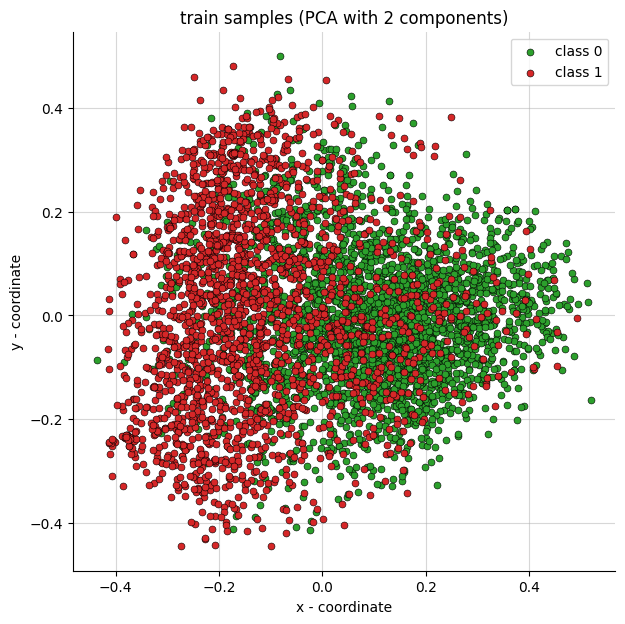

In [360]:
plt.rcParams['figure.figsize']=7, 7
fig = plt.figure()

ax = fig.add_subplot(111)

ax.scatter(Z_0[:, 0], Z_0[:, 1], zorder=3, c="tab:green", edgecolor="black", linewidth=0.4, s=25, label="class 0")
ax.scatter(Z_1[:, 0], Z_1[:, 1], zorder=3, c="tab:red", edgecolor="black", linewidth=0.4, s=25, label="class 1")
ax.set_xlabel("x - coordinate", fontsize=10)
ax.set_ylabel("y - coordinate", fontsize=10)
ax.set_title("train samples (PCA with 2 components)", fontsize=12)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

plt.show()

# Let's start with the classification methods


In [361]:
def train_list_of_models(model_list: list, train_features_list: list):
    for model, train_f in zip(model_list, train_features_list):
        model.fit(train_f, train_target)
    return model_list

In [362]:
def get_metrics_list_of_models(model_list: list, train_features_list: list, val_features_list: list, model_name: str, dim_list: list):
    df = pd.DataFrame()

    for model, train_f, val_f, dim in zip(model_list, train_features_list, val_features_list, dim_list):
        train_predict = model.predict(train_f)
        val_predict = model.predict(val_f)
        train_acc = accuracy_score(train_target, train_predict)
        train_f1 = f1_score(train_target, train_predict)
        val_acc = accuracy_score(val_target, val_predict)
        val_f1 = f1_score(val_target, val_predict)
        df_ = pd.DataFrame({
            "Model": [model_name+"-"+str(dim)],
            "Train Accuracy": [train_acc],
            "Train F1": [train_f1],
            "Val Accuracy": [val_acc],
            "Val F1": [val_f1]
        })
        df = pd.concat([df, df_])
    
    df = df.set_index("Model")
    return df

We are going to start with the most basic ones and then the most complex ones

## Logistic Regression

In [363]:
from sklearn.linear_model import LogisticRegression

logistic_regression_list = [LogisticRegression(penalty="l2") for _ in train_features_list]
logistic_regression_list = train_list_of_models(logistic_regression_list, train_features_list)
logistics_regression_df = get_metrics_list_of_models(logistic_regression_list, 
                        train_features_list, val_features_list,
                        "Logistic Regression", dim_list)
logistics_regression_df

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
Logistic Regression-768,0.845634,0.812485,0.817761,0.779439
Logistic Regression-100,0.829985,0.793427,0.807722,0.764428
Logistic Regression-10,0.818393,0.782105,0.804633,0.765524
Logistic Regression-2,0.787287,0.748917,0.768340,0.727768


## KNeighborsClassifier

In [364]:
from sklearn.neighbors import KNeighborsClassifier

knn_list = [KNeighborsClassifier(n_neighbors=15) for _ in train_features_list]
knn_list = train_list_of_models(knn_list, train_features_list)
knn_df = get_metrics_list_of_models(knn_list, 
                        train_features_list, val_features_list,
                        "KNN", dim_list)
knn_df

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
KNN-768,0.818779,0.797408,0.785328,0.764805
KNN-100,0.844668,0.812587,0.825483,0.792661
KNN-10,0.833849,0.792571,0.813900,0.769819
KNN-2,0.806221,0.762828,0.772201,0.726091


## Decision Tree Classifier

In [365]:
from sklearn.tree import DecisionTreeClassifier

depth_list = [8, 8, 8, 8]
tree_list = [DecisionTreeClassifier(max_depth=depth) for _, depth in zip(train_features_list, depth_list)]
tree_list = train_list_of_models(tree_list, train_features_list)
tree_df = get_metrics_list_of_models(tree_list, 
                        train_features_list, val_features_list,
                        "Decision Treen", dim_list)
tree_df

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
Decision Treen-768,0.904946,0.884939,0.731274,0.671698
Decision Treen-100,0.890649,0.868250,0.779923,0.732896
Decision Treen-10,0.867272,0.838695,0.784556,0.740947
Decision Treen-2,0.820711,0.772102,0.772201,0.708210


## Perceptron

In [366]:
from sklearn.linear_model import Perceptron

perceptron_list = [Perceptron(penalty="l2") for _ in train_features_list]
perceptron_list = train_list_of_models(perceptron_list, train_features_list)
perceptron_df = get_metrics_list_of_models(perceptron_list, 
                        train_features_list, val_features_list,
                        "Perceptron", dim_list)
perceptron_df

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
Perceptron-768,0.764683,0.635548,0.745174,0.598540
Perceptron-100,0.715031,0.532784,0.717375,0.544776
Perceptron-10,0.785742,0.760734,0.771429,0.747009
Perceptron-2,0.446484,0.606726,0.447876,0.610778


## Linear Support Vector Machines

In [367]:
from sklearn.svm import LinearSVC

linear_svm_list = [LinearSVC(dual="auto") for _ in train_features_list]
linear_svm_list = train_list_of_models(linear_svm_list, train_features_list)
linear_svm_df = get_metrics_list_of_models(linear_svm_list, 
                        train_features_list, val_features_list,
                        "Linear SVM", dim_list)
linear_svm_df

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
Linear SVM-768,0.859930,0.828158,0.820849,0.782364
Linear SVM-100,0.829405,0.792382,0.806178,0.763431
Linear SVM-10,0.816654,0.780781,0.806950,0.768946
Linear SVM-2,0.786901,0.750622,0.769884,0.732014


## Support Vector Machines

In [368]:
from sklearn.svm import SVC

svm_list = [SVC() for _ in train_features_list]
svm_list = train_list_of_models(svm_list, train_features_list)
svm_df = get_metrics_list_of_models(svm_list, 
                        train_features_list, val_features_list,
                        "SVM", dim_list)
svm_df

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
SVM-768,0.909196,0.887828,0.830888,0.788814
SVM-100,0.900889,0.876772,0.833977,0.788594
SVM-10,0.842156,0.800877,0.823166,0.777886
SVM-2,0.794822,0.749646,0.774517,0.728119


## Random Forest

In [369]:
from sklearn.ensemble import RandomForestClassifier

random_forest_list = [RandomForestClassifier(max_depth=6) for _ in train_features_list]
random_forest_list = train_list_of_models(random_forest_list, train_features_list)
random_forest_df = get_metrics_list_of_models(random_forest_list, 
                        train_features_list, val_features_list,
                        "Random Forest", dim_list)
random_forest_df

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
Random Forest-768,0.879250,0.848043,0.803861,0.747012
Random Forest-100,0.841577,0.797930,0.796911,0.741904
Random Forest-10,0.837133,0.797793,0.796139,0.747126
Random Forest-2,0.810858,0.765397,0.773745,0.720686


## Logistic Regression Bagging

In [370]:
from sklearn.ensemble import BaggingClassifier

lr_bagging_list = [BaggingClassifier(estimator=LogisticRegression(penalty="l2")) for _ in train_features_list]
lr_bagging_list = train_list_of_models(lr_bagging_list, train_features_list)
lr_df = get_metrics_list_of_models(lr_bagging_list, 
                        train_features_list, val_features_list,
                        "Logistic Regression Bagging", dim_list)
lr_df

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
Logistic Regression Bagging-768,0.844861,0.811192,0.820077,0.780809
Logistic Regression Bagging-100,0.828825,0.792116,0.810811,0.769086
Logistic Regression Bagging-10,0.818393,0.781294,0.806178,0.766945
Logistic Regression Bagging-2,0.787674,0.749029,0.765251,0.723636


## Decision Tree Bagging

In [371]:
from sklearn.ensemble import BaggingClassifier

tree_bagging_list = [BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5)) for _ in train_features_list]
tree_bagging_list = train_list_of_models(tree_bagging_list, train_features_list)
tree_bagging_df = get_metrics_list_of_models(tree_bagging_list, 
                        train_features_list, val_features_list,
                        "Decision Tree Bagging", dim_list)
tree_bagging_df

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
Decision Tree Bagging-768,0.848532,0.812350,0.789189,0.734177
Decision Tree Bagging-100,0.846020,0.811539,0.796139,0.750473
Decision Tree Bagging-10,0.832110,0.795481,0.797683,0.751894
Decision Tree Bagging-2,0.804096,0.756484,0.771429,0.718631


## Logistic Regression AdaBoost

In [372]:
from sklearn.ensemble import AdaBoostClassifier

lr_ada_list = [AdaBoostClassifier(estimator=LogisticRegression(penalty="l2")) for _ in train_features_list]
lr_ada_list = train_list_of_models(lr_ada_list, train_features_list)
lr_ada_df = get_metrics_list_of_models(lr_ada_list, 
                        train_features_list, val_features_list,
                        "Logistic Regression AdaBoost", dim_list)
lr_ada_df

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
Logistic Regression AdaBoost-768,0.801971,0.730334,0.789961,0.713080
Logistic Regression AdaBoost-100,0.799652,0.726890,0.786873,0.708861
Logistic Regression AdaBoost-10,0.793470,0.718610,0.776834,0.695469
Logistic Regression AdaBoost-2,0.774730,0.688402,0.756757,0.663821


In [373]:
from sklearn.ensemble import AdaBoostClassifier

tree_ada_list = [AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2)) for _ in train_features_list]
tree_ada_list = train_list_of_models(tree_ada_list, train_features_list)
tree_ada_df = get_metrics_list_of_models(tree_ada_list, 
                        train_features_list, val_features_list,
                        "Decision Tree AdaBoost", dim_list)
tree_ada_df

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
Decision Tree AdaBoost-768,0.883694,0.860713,0.767568,0.724106
Decision Tree AdaBoost-100,0.867079,0.840297,0.789189,0.747456
Decision Tree AdaBoost-10,0.847952,0.817697,0.778378,0.734505
Decision Tree AdaBoost-2,0.810085,0.767887,0.774517,0.727103


Joining all the results from linear models

In [374]:
df_linear_models = pd.concat([
    logistics_regression_df, knn_df, tree_df, perceptron_df, linear_svm_df, svm_df, 
    random_forest_df, lr_df, tree_bagging_df, lr_ada_df, tree_ada_df
])

Sorting for the validation F1 score

In [375]:
df_linear_models.sort_values("Val F1", ascending=False)

,Train Accuracy,Train F1,Val Accuracy,Val F1
Model,,,,
KNN-100,0.844668,0.812587,0.825483,0.792661
SVM-768,0.909196,0.887828,0.830888,0.788814
SVM-100,0.900889,0.876772,0.833977,0.788594
Linear SVM-768,0.859930,0.828158,0.820849,0.782364
Logistic Regression Bagging-768,0.844861,0.811192,0.820077,0.780809
Logistic Regression-768,0.845634,0.812485,0.817761,0.779439
SVM-10,0.842156,0.800877,0.823166,0.777886
KNN-10,0.833849,0.792571,0.813900,0.769819
Logistic Regression Bagging-100,0.828825,0.792116,0.810811,0.769086


With this, one can see that the best tree models in validation F1 scores are KNN-100, SVM-100 and Logistic Regression Bagging-100

In [150]:
KNN_100 = knn_list[1]
SVM_100 = svm_list[1]
LR_B_100 = lr_bagging_list[1]

We are going to generate the predictions from the test set and then get its scores in Kaggle.

In [158]:
test_prediction_knn_100 = KNN_100.predict(test_features_list[1])
test_prediction_svm_100 = SVM_100.predict(test_features_list[1])
test_prediction_lr_b_100 = LR_B_100.predict(test_features_list[1])

In [165]:
df_sample_sub = pd.read_csv("nlp-getting-started/sample_submission.csv", index_col=False)
knn_sub = df_sample_sub.copy()
svm_sub = df_sample_sub.copy()
lr_b_sub = df_sample_sub.copy()

In [171]:
knn_sub["target"] = test_prediction_knn_100.astype(np.int16)
svm_sub["target"] = test_prediction_svm_100.astype(np.int16)
lr_b_sub["target"] = test_prediction_lr_b_100.astype(np.int16)

In [173]:
knn_sub.to_csv("nlp-getting-started/submissions/knn_100.csv", index=False)
svm_sub.to_csv("nlp-getting-started/submissions/svm_100.csv", index=False)
lr_b_sub.to_csv("nlp-getting-started/submissions/lr_b_100.csv", index=False)

KNN_100 got 0.819 Test F1 Score

SVM_100 got 0.825 Test F1 Score

LR_B_100 got 0.801 Test F1 Score

Now we are going to start to use Deep Learning Methods for the classification task

## Feed Forward Neural Network

In [325]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

In [326]:
train_ds = pd.read_csv("nlp-getting-started/encoded_train_large.csv", index_col=False)
test_ds = pd.read_csv("nlp-getting-started/encoded_test_large.csv", index_col=False)

In [327]:
train_ds = np.array(train_ds)
test_ds = np.array(test_ds)

In [328]:
train_data, val_data = train_test_split(train_ds, test_size=0.2)

In [329]:
train_target = train_data[:, -1]
train_features = train_data[:, :-1]
val_target = val_data[:, -1]
val_features = val_data[:, :-1]
test_features = test_ds

We start creating the dataloader, as we are going to use more powerfull methods we will use the dataset with all features

In [330]:
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Let's define the model

In [331]:
class Layer(nn.Module):
    def __init__(self, n_input: int, n_output: int, dropout: float, activation: bool):
        super().__init__()
        if activation:
            self.layer = nn.Sequential(
                nn.Dropout(dropout),
                nn.BatchNorm1d(n_input),
                nn.Linear(n_input, n_output),
                nn.ReLU(),
            )
        else:
            self.layer = nn.Sequential(
                nn.Dropout(dropout),
                nn.BatchNorm1d(n_input),
                nn.Linear(n_input, n_output)
            )
        
        
    def forward(self, x: torch.Tensor):
        x_ = self.layer(x)
        return x_

class FeedForwardClassification(nn.Module):
    def __init__(self, layers: list):
        super().__init__()
        self.sequential = nn.Sequential(
            *[Layer(*layer) for layer in layers]
        )
    
    def forward(self, x):
        x_ = self.sequential(x)
        return x_

Now we need to define the training algorithm

In [332]:
train_data.shape

(5176, 769)

In [346]:
layers = [[768, 1000, 0.3, True], [1000, 1, 0.5, False]]
model = FeedForwardClassification(layers).to(device)

epochs = 221
lr = 1e-7
optimizer = Adam(model.parameters(), lr=lr)
loss = BCEWithLogitsLoss()
loss_list = {"train": [], "val": [], "train_acc": [], "trai_f1": [], "val_acc": [],  "val_f1": []}
sigmoid = nn.Sigmoid()
schedular = ExponentialLR(optimizer, gamma=0.95)

model

FeedForwardClassification(
  (sequential): Sequential(
    (0): Layer(
      (layer): Sequential(
        (0): Dropout(p=0.3, inplace=False)
        (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=768, out_features=1000, bias=True)
        (3): ReLU()
      )
    )
    (1): Layer(
      (layer): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=1000, out_features=1, bias=True)
      )
    )
  )
)

In [376]:

n_groups = 10
group_epochs = epochs // n_groups
for _ in range(group_epochs):
    for epoch in tqdm(range(n_groups)):
        model.train()
        running_loss = []
        y_hat_list = []
        y_list = []
        
        for batch in train_dataloader:
            x = batch[:, :-1].to(device).float()
            y = batch[:, -1].to(device).float()
            y_hat = model(x)
            
            output = loss(y_hat.squeeze(), y)
            
            y_hat_list.append(sigmoid(y_hat))
            y_list.append(y)
            
            output.backward()
            optimizer.step()
            running_loss.append(output.item())

        y_hat_list = torch.round(torch.concat([y_hat for y_hat in y_hat_list]))
        y_list = torch.concat([y for y in y_list])
        acc = accuracy_score(y_list.tolist(), y_hat_list.tolist())
        f1 = f1_score(y_list.tolist(), y_hat_list.tolist())
        epoch_loss = np.mean(running_loss)
        
        model.eval()
        running_loss_val = []
        y_hat_list_val = []
        y_list_val = []
        for batch in val_dataloader:
            x = batch[:, :-1].to(device).float()
            y = batch[:, -1].to(device).float()
            y_hat = model(x)
            
            output = loss(y_hat.squeeze(), y)
            y_hat_list_val.append(sigmoid(y_hat))
            y_list_val.append(y)
            
            running_loss_val.append(output.item())
            
        y_hat_list_val = torch.round(torch.concat([y_hat for y_hat in y_hat_list_val]))
        y_list_val = torch.concat([y for y in y_list_val])
        acc_val = accuracy_score(y_list_val.tolist(), y_hat_list_val.tolist())
        f1_val = f1_score(y_list_val.tolist(), y_hat_list_val.tolist())
        epoch_loss_val = np.mean(running_loss_val)
        
    #schedular.step()
        

    print(f"Train: Loss: {round(epoch_loss, 4)}. Acc: {round(acc, 4)}. F1: {round(f1, 4)}")
    print(f"Validation: Loss: {round(epoch_loss_val, 4)}. Acc: {round(acc_val, 4)}. F1: {round(f1_val, 4)}")
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train: Loss: 0.3692. Acc: 0.84. F1: 0.8056
Validation: Loss: 0.3937. Acc: 0.8355. F1: 0.7992



100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Train: Loss: 0.3672. Acc: 0.8398. F1: 0.8054
Validation: Loss: 0.3847. Acc: 0.834. F1: 0.7985



100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Train: Loss: 0.3626. Acc: 0.84. F1: 0.8051
Validation: Loss: 0.3917. Acc: 0.8363. F1: 0.8026



100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Train: Loss: 0.3712. Acc: 0.8377. F1: 0.8028
Validation: Loss: 0.385. Acc: 0.8355. F1: 0.7985



100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Train: Loss: 0.375. Acc: 0.8389. F1: 0.8038
Validation: Loss: 0.3905. Acc: 0.8355. F1: 0.7969



100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Train: Loss: 0.3682. Acc: 0.8454. F1: 0.8113
Validation: Loss: 0.3826. Acc: 0.8347. F1: 0.7992



100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Train: Loss: 0.3662. Acc: 0.8429. F1: 0.8083
Validation: Loss: 0.3874. Acc: 0.834. F1: 0.7935



100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Train: Loss: 0.365. Acc: 0.8427. F1: 0.8077
Validation: Loss: 0.3906. Acc: 0.834. F1: 0.797



100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Train: Loss: 0.3696. Acc: 0.8423. F1: 0.8067
Validation: Loss: 0.3816. Acc: 0.8347. F1: 0.7985



100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Train: Loss: 0.3588. Acc: 0.8443. F1: 0.8104
Validation: Loss: 0.3842. Acc: 0.8347. F1: 0.7981



100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Train: Loss: 0.3549. Acc: 0.8466. F1: 0.8134
Validation: Loss: 0.3849. Acc: 0.8355. F1: 0.7985



100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Train: Loss: 0.3625. Acc: 0.8445. F1: 0.8096
Validation: Loss: 0.3883. Acc: 0.8347. F1: 0.7977



100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Train: Loss: 0.3685. Acc: 0.8433. F1: 0.8088
Validation: Loss: 0.3905. Acc: 0.8355. F1: 0.7989



100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Train: Loss: 0.3656. Acc: 0.8462. F1: 0.812
Validation: Loss: 0.3853. Acc: 0.8347. F1: 0.7989



100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Train: Loss: 0.3632. Acc: 0.8478. F1: 0.8145
Validation: Loss: 0.3811. Acc: 0.8378. F1: 0.8019



100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Train: Loss: 0.3595. Acc: 0.8431. F1: 0.8082
Validation: Loss: 0.3961. Acc: 0.8363. F1: 0.8019



100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Train: Loss: 0.3604. Acc: 0.8501. F1: 0.8165
Validation: Loss: 0.3866. Acc: 0.8371. F1: 0.7989



100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Train: Loss: 0.3609. Acc: 0.8483. F1: 0.8149
Validation: Loss: 0.3864. Acc: 0.8378. F1: 0.7996



100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Train: Loss: 0.3692. Acc: 0.8435. F1: 0.8094
Validation: Loss: 0.3903. Acc: 0.8371. F1: 0.7985



100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Train: Loss: 0.361. Acc: 0.8481. F1: 0.8143
Validation: Loss: 0.3861. Acc: 0.8371. F1: 0.7989



100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Train: Loss: 0.3636. Acc: 0.8445. F1: 0.8099
Validation: Loss: 0.3881. Acc: 0.8394. F1: 0.803



100%|██████████| 10/10 [00:09<00:00,  1.02it/s]

Train: Loss: 0.3649. Acc: 0.8474. F1: 0.8139
Validation: Loss: 0.3898. Acc: 0.8386. F1: 0.8023



In [377]:
model.eval()
y_hat = model(torch.tensor(test_features).float())

In [378]:
y_hat = sigmoid(y_hat.squeeze())

In [379]:
y_hat = torch.round(y_hat)

In [380]:
y_hat

tensor([0., 1., 1.,  ..., 1., 1., 1.], grad_fn=<RoundBackward0>)

In [381]:
mlp_sub = df_sample_sub.copy()
mlp_sub["target"] = y_hat.int().tolist()

In [382]:
mlp_sub.to_csv("nlp-getting-started/submissions/mlp_1_large.csv", index=False)

In [289]:
y_hat.int()

tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)